In [1]:
import copy
import os
import random
import sys
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class _VGG_16(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.vgg16(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(1000, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x
    
class Resnet_18(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [113]:
import cv2  # OpenCV for applying colormap

def visualize_gradcam(heatmap, original_image):
    # Scale the heatmap to 0-255
    heatmap = np.uint8(heatmap * 255)

    # Apply a colormap to make it colorful
    colored_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert the original image to a NumPy array
    original_image = np.asarray(original_image)

    # Resize heatmap to match the original image size
    colored_heatmap = cv2.resize(colored_heatmap, (original_image.shape[1], original_image.shape[0]))

    # Overlay the heatmap on the original image
    overlay = 0.5 * original_image + 0.5 * colored_heatmap
    overlay = np.uint8(overlay)

    # Plot images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Colored Heatmap")
    plt.imshow(cv2.cvtColor(colored_heatmap, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [126]:

# Grad-CAM Helper Class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None
        self.gradients = None

        # Register hooks to capture features and gradients
        self.target_layer.register_forward_hook(self.save_features)
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_features(self, module, input, output):
        self.feature_maps = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, class_idx):
        # Average the gradients across the channels
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # Compute weighted sum of feature maps
        heatmap = torch.sum(weights * self.feature_maps, dim=1).squeeze()

        # ReLU to remove negative values
        heatmap = F.relu(heatmap)

        # Normalize the heatmap to [0, 1]
        heatmap = heatmap - heatmap.min()
        heatmap = heatmap / heatmap.max()
        return heatmap.cpu().detach().numpy()

# Load your image
img_path = "/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/DeepDRiD/val/265/265_l1.jpg"
image = Image.open(img_path).convert("RGB")

# Define image transformations
image_size = 256
transform = transforms.Compose([
    transforms.Resize(image_size, antialias=True),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

img_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Initialize your model
vgg16_model = _VGG_16()
vgg_sd_path = '/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/results/ensemble_models/vgg_16.pth'
vgg_sd = torch.load(vgg_sd_path, map_location='cpu')
vgg16_model.load_state_dict(vgg_sd)
vgg16_model.eval()

# Identify the last convolutional layer
last_conv_layer = vgg16_model.backbone.features[-4]  # Adjust based on your model structure

# Initialize Grad-CAM
grad_cam = GradCAM(vgg16_model, last_conv_layer)

# Forward pass
output = vgg16_model(img_tensor)
predicted_class = output.argmax(dim=1).item()

# Backward pass for Grad-CAM
vgg16_model.zero_grad()
output[:, predicted_class].backward()

# Generate heatmap
heatmap = grad_cam.generate_heatmap(predicted_class)

/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/2s/t87m92j14g9b1yw35n324r5w0000gn/T/ipykernel_6681/3674291818.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct mal

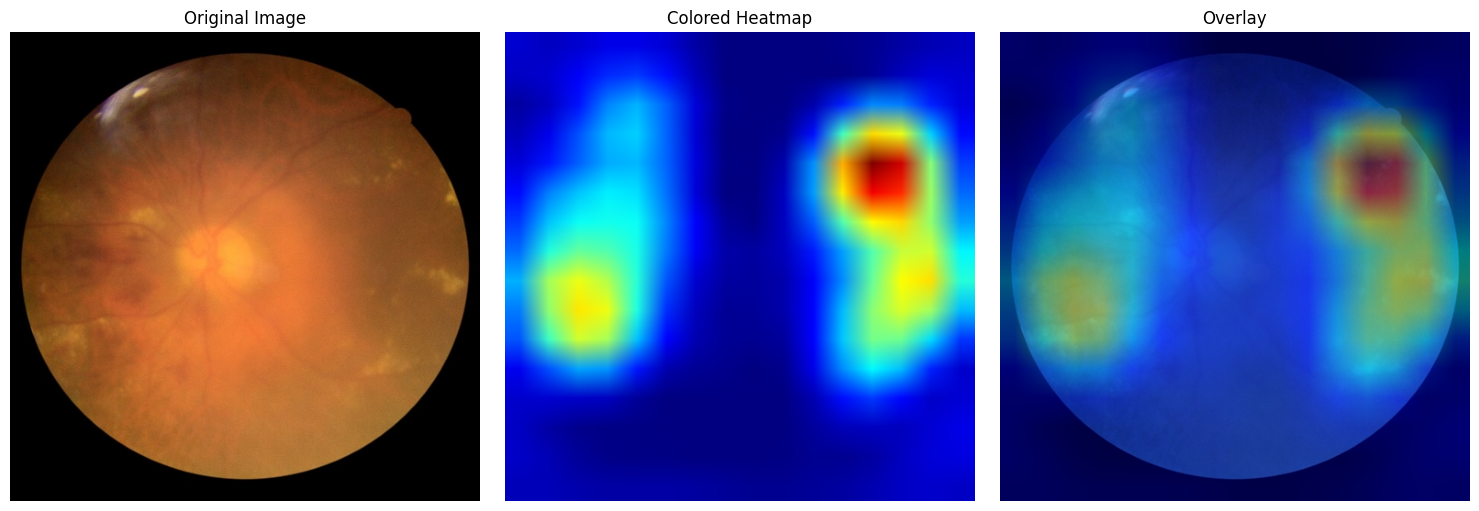

In [97]:
visualize_gradcam(heatmap, image)

/var/folders/2s/t87m92j14g9b1yw35n324r5w0000gn/T/ipykernel_31272/4041821335.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg_sd = torch.load(vgg_sd_path, map_locatio

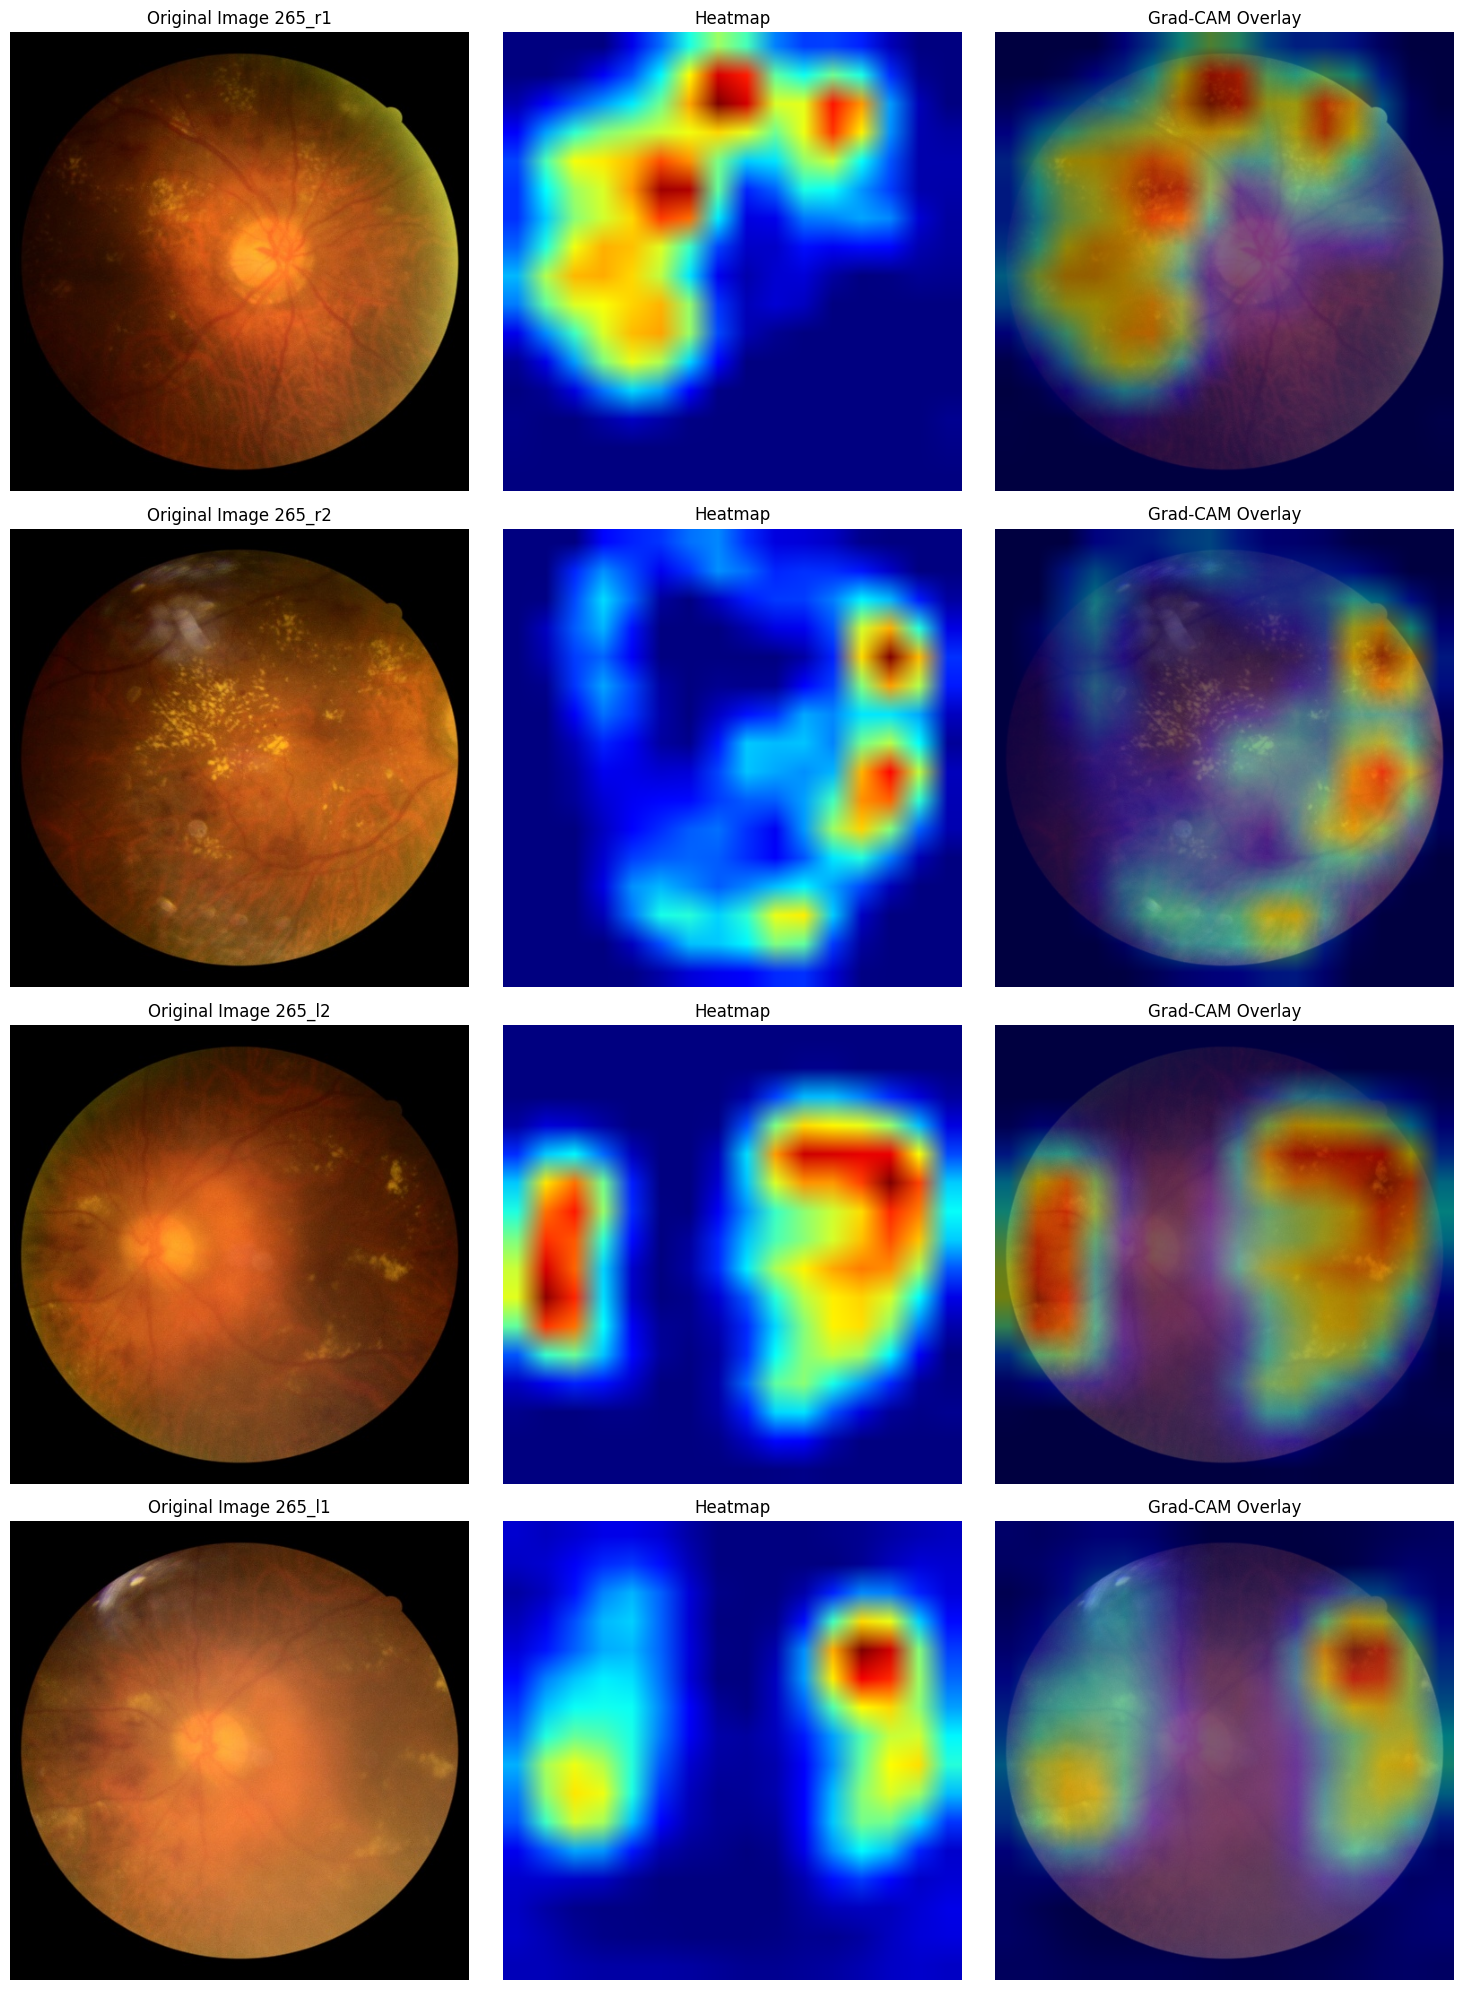

In [19]:
import os
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Grad-CAM Helper Class (unchanged)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None
        self.gradients = None

        # Register hooks to capture features and gradients
        self.target_layer.register_forward_hook(self.save_features)
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_features(self, module, input, output):
        self.feature_maps = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, class_idx):
        # Average the gradients across the channels
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # Compute weighted sum of feature maps
        heatmap = torch.sum(weights * self.feature_maps, dim=1).squeeze()

        # ReLU to remove negative values
        heatmap = F.relu(heatmap)

        # Normalize the heatmap to [0, 1]
        heatmap = heatmap - heatmap.min()
        heatmap = heatmap / heatmap.max()
        return heatmap.cpu().detach().numpy()

# Define image transformations
image_size = 256
transform = transforms.Compose([
    transforms.Resize(image_size, antialias=True),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Function to visualize Grad-CAM heatmaps
def visualize_gradcam(heatmap, original_image):
    # Scale the heatmap to 0-255
    heatmap = np.uint8(heatmap * 255)

    # Apply a colormap to make it colorful
    colored_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert the original image to a NumPy array (ensure it's in RGB)
    original_image = np.asarray(original_image)
    
    # Convert the original image to RGB if it's in BGR
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match the original image size
    colored_heatmap = cv2.resize(colored_heatmap, (original_image_rgb.shape[1], original_image_rgb.shape[0]))

    # Overlay the heatmap on the original image
    overlay = 0.5 * original_image_rgb + 0.5 * colored_heatmap
    overlay = np.uint8(overlay)

    return original_image, colored_heatmap, overlay

# Load the model
vgg16_model = _VGG_16()
vgg_sd_path = '/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/results/ensemble_models/vgg_16.pth'
vgg_sd = torch.load(vgg_sd_path, map_location='cpu')
vgg16_model.load_state_dict(vgg_sd)
vgg16_model.eval()

# Identify the last convolutional layer
last_conv_layer = vgg16_model.backbone.features[-4]  # Adjust based on your model structure

# Initialize Grad-CAM
grad_cam = GradCAM(vgg16_model, last_conv_layer)

# Get all images in the directory
image_dir = "/Users/shakibibnashameem/Documents/Practice/deep_learning_fall_2024/final_project/data/DeepDRiD/val/265"
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]


#imag titles
img_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
image_titles = [os.path.splitext(f)[0] for f in img_files]


# Prepare the plot (12 images, 3 plots per image)
fig, axs = plt.subplots(4, 3, figsize=(15, 20))

# Process each image and create plots
for i, img_file in enumerate(image_files[:12]):  # Only take the first 12 images for a 12x3 grid
    img_path = os.path.join(image_dir, img_file)
    image = Image.open(img_path).convert("RGB")

    # Apply transformations
    img_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Forward pass
    output = vgg16_model(img_tensor)
    predicted_class = output.argmax(dim=1).item()

    # Backward pass for Grad-CAM
    vgg16_model.zero_grad()
    output[:, predicted_class].backward()

    # Generate heatmap
    heatmap = grad_cam.generate_heatmap(predicted_class)

    # Visualize the Grad-CAM results
    original_image_rgb, colored_heatmap, overlay = visualize_gradcam(heatmap, image)

    # Plot the images in the grid
    axs[i, 0].imshow(original_image_rgb)  # Original Image (RGB)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f"Original Image {image_titles[i]}")

    axs[i, 1].imshow(cv2.cvtColor(colored_heatmap, cv2.COLOR_BGR2RGB))  # Heatmap
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f"Heatmap")

    axs[i, 2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))  # Grad-CAM Overlay
    axs[i, 2].axis('off')
    axs[i, 2].set_title(f"Grad-CAM Overlay")

plt.tight_layout()
plt.show()
